In [1]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv('../input/tamil-df1/df_tamil1.csv',  index_col=[0])
df.head()

,id,context,question,answer_text,answer_start,language
0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன?,206,53,tamil
1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்?,காசுமீரில்,2358,tamil
2,29d154b56,சர் அலெக்ஸாண்டர் ஃபிளெமிங் (Sir Alexander Flem...,பென்சிலின் கண்டுபிடித்தவர் யார்?,சர் அலெக்ஸாண்டர் ஃபிளெமிங்,0,tamil
3,41660850a,"குழந்தையின் அழுகையை நிறுத்தவும், தூங்க வைக்கவ...",தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பா...,தாலாட்டு,68,tamil
4,b29c82c22,சூரியக் குடும்பம் \nசூரியக் குடும்பம் (Solar S...,பூமியின் அருகில் உள்ள விண்மீன் எது?,சூரியனும்,585,tamil


In [7]:
df.shape

(368, 6)

In [21]:
train = df.copy()

In [22]:
train.language.value_counts()

tamil    368
Name: language, dtype: int64

In [25]:
import transformers

In [26]:
#model_checkpoint = '../input/tamillion/Tamillion'
#batch_size = 4

In [28]:
model_checkpoint = 'deepset/xlm-roberta-large-squad2'
batch_size = 4

In [29]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [32]:
tokenizer(train['context'][1]).keys()

Token indices sequence length is longer than the specified maximum sequence length for this model (2316 > 512). Running this sequence through the model will result in indexing errors


dict_keys(['input_ids', 'attention_mask'])

The input_ids are simply the numeric representations of the tokens. Attention_mask is useful when we add padding to the input tokens. The attention mask tells us which input_ids correspond to padding.  Padding is added because we want all the input sentences to be of the same length (at least for a batch) so that we are able to form tensor objects properly.

We can now see what the attention_mask is all about: it points out which tokens the model should pay attention to and which ones it should not (because they represent padding in this case).

In [33]:
train['num_tokens_context'] = train['context'].apply(lambda t: len(tokenizer(t)['input_ids']))

Looks like the context can get pretty long, so we'll need to divide it into pieces before processing. 

<AxesSubplot:>

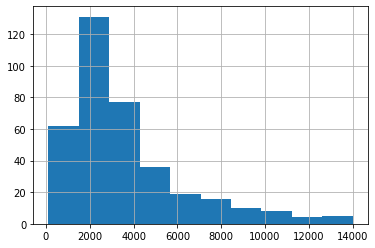

In [34]:
train['num_tokens_context'].hist()

In [35]:
max(train['num_tokens_context'])

14011

In [36]:
max_length = 384
doc_stride = 128 

In [37]:
pad_on_right = tokenizer.padding_side == "right"

In [38]:
pad_on_right

True

In [39]:
def prepare_train_features(examples):
   
    examples["question"] = [q.lstrip() for q in examples["question"]]
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )


    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sequence_ids = tokenized_examples.sequence_ids(i)

        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
    
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

           
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

           .
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1
.
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [40]:
!pip uninstall fsspec -qq -y
!pip install --no-index --find-links ../input/hf-datasets/wheels datasets -qq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cloud 0.1.13 requires tensorflow<3.0,>=1.15.0, which is not installed.
dask-cudf 21.6.1+2.g101fc0fda4 requires cupy-cuda112, which is not installed.
cudf 21.6.1+2.g101fc0fda4 requires cupy-cuda110, which is not installed.
s3fs 2021.6.1 requires fsspec==2021.06.1, but you have fsspec 2021.6.0 which is incompatible.
pytorch-lightning 1.3.8 requires fsspec[http]!=2021.06.0,>=2021.05.0, but you have fsspec 2021.6.0 which is incompatible.
dask-cudf 21.6.1+2.g101fc0fda4 requires dask<=2021.5.1,>=2021.4.0, but you have dask 2021.6.2 which is incompatible.
dask-cudf 21.6.1+2.g101fc0fda4 requires distributed<=2021.5.1,>=2.22.0, but you have distributed 2021.6.2 which is incompatible.


In [41]:
from datasets import Dataset

In [42]:
def convert_answers(r):
    start = r[0]
    text = r[1]
    return {
        'answer_start': [start],
        'text': [text]
    }

In [43]:
train = train.sample(frac=1, random_state=42)
train['answers'] = train[['answer_start', 'answer_text']].apply(convert_answers, axis=1)

In [44]:
train.head()

,id,context,question,answer_text,answer_start,language,num_tokens_context,answers
165,83f5c039a,மைக்ரோசாப்ட் நிறுவனம்(Microsoft Corporation) அ...,மைக்ரோசாப்ட் நிறுவனம் யாரால் நிறுவப்பட்டது?,பில் கேட்சும் பவுல் ஆல்லெனும்,396,tamil,1250,"{'answer_start': [396], 'text': ['பில் கேட்சும..."
33,4b69614bc,"விலங்குகள் (Animals), அனிமாலியா (Animalia) அல்...",உருளைப்புழு எந்த தொகுதியை சேர்ந்தது?,நெமடோடா,12028,tamil,5441,"{'answer_start': [12028], 'text': ['நெமடோடா']}"
15,873ee70ee,சாக்கிரட்டீசு (Socrates) (கி.மு 470/469 – கி....,சாக்கிரட்டீசு எப்போது பிறந்தார்?,கி.மு. ஐந்தாம் நூற்றாண்டில்,2905,tamil,2743,"{'answer_start': [2905], 'text': ['கி.மு. ஐந்த..."
312,7bea4014a,"பனை (Palmyra Palm), புல்லினத்தைச் சேர்ந்த ஒரு ...",பனை மரத்தின் அறிவியல் பெயர் என்ன?,போரசசு,91,tamil,2847,"{'answer_start': [91], 'text': ['போரசசு']}"
57,ecc19a740,நோபெல் பரிசு (Nobel Prize) அல்லது நோபல் பரிசு ...,நோபல் பரிசு எந்த ஆண்டு முதல் முதலில் வழங்கப்பட...,1901,557,tamil,3933,"{'answer_start': [557], 'text': ['1901']}"


In [45]:
df_train = train[:-64].reset_index(drop=True)
df_valid = train[-64:].reset_index(drop=True)

In [46]:
df_train.head()

,id,context,question,answer_text,answer_start,language,num_tokens_context,answers
0,83f5c039a,மைக்ரோசாப்ட் நிறுவனம்(Microsoft Corporation) அ...,மைக்ரோசாப்ட் நிறுவனம் யாரால் நிறுவப்பட்டது?,பில் கேட்சும் பவுல் ஆல்லெனும்,396,tamil,1250,"{'answer_start': [396], 'text': ['பில் கேட்சும..."
1,4b69614bc,"விலங்குகள் (Animals), அனிமாலியா (Animalia) அல்...",உருளைப்புழு எந்த தொகுதியை சேர்ந்தது?,நெமடோடா,12028,tamil,5441,"{'answer_start': [12028], 'text': ['நெமடோடா']}"
2,873ee70ee,சாக்கிரட்டீசு (Socrates) (கி.மு 470/469 – கி....,சாக்கிரட்டீசு எப்போது பிறந்தார்?,கி.மு. ஐந்தாம் நூற்றாண்டில்,2905,tamil,2743,"{'answer_start': [2905], 'text': ['கி.மு. ஐந்த..."
3,7bea4014a,"பனை (Palmyra Palm), புல்லினத்தைச் சேர்ந்த ஒரு ...",பனை மரத்தின் அறிவியல் பெயர் என்ன?,போரசசு,91,tamil,2847,"{'answer_start': [91], 'text': ['போரசசு']}"
4,ecc19a740,நோபெல் பரிசு (Nobel Prize) அல்லது நோபல் பரிசு ...,நோபல் பரிசு எந்த ஆண்டு முதல் முதலில் வழங்கப்பட...,1901,557,tamil,3933,"{'answer_start': [557], 'text': ['1901']}"


In [47]:
train_dataset = Dataset.from_pandas(df_train)
valid_dataset = Dataset.from_pandas(df_valid)

In [48]:
train_dataset

Dataset({
    features: ['id', 'context', 'question', 'answer_text', 'answer_start', 'language', 'num_tokens_context', 'answers'],
    num_rows: 304
})

In [49]:
tokenized_train_ds = train_dataset.map(prepare_train_features, batched=True, remove_columns=train_dataset.column_names)
tokenized_valid_ds = valid_dataset.map(prepare_train_features, batched=True, remove_columns=train_dataset.column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [50]:
len(tokenized_train_ds['input_ids'])

4628

In [51]:
tokenized_train_ds['start_positions'][1],tokenized_train_ds['end_positions'][1]

(0, 0)

In [52]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

In [53]:
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


In [54]:
args = TrainingArguments(
    f"chaii-qa",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-5,
    warmup_ratio=0.1,
    gradient_accumulation_steps=8,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=0.01,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [55]:
from transformers import default_data_collator

data_collator = default_data_collator

In [56]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_valid_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [57]:
trainer.train()

Epoch,Training Loss,Validation Loss
0,No log,0.311393


TrainOutput(global_step=144, training_loss=0.309766239590115, metrics={'train_runtime': 704.5005, 'train_samples_per_second': 0.204, 'total_flos': 0, 'epoch': 1.0, 'init_mem_cpu_alloc_delta': -540286976, 'init_mem_gpu_alloc_delta': 2235376640, 'init_mem_cpu_peaked_delta': 1023119360, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 64765952, 'train_mem_gpu_alloc_delta': 6733405184, 'train_mem_cpu_peaked_delta': 3086770176, 'train_mem_gpu_peaked_delta': 5504041984})

In [58]:
trainer.save_model("bert-trained")

In [59]:
def prepare_validation_features(examples):
    
    examples["question"] = [q.lstrip() for q in examples["question"]]

   
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

   
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [60]:
validation_features = valid_dataset.map(
    prepare_validation_features,
    batched=True,
    remove_columns=valid_dataset.column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [61]:
len(validation_features)

883

In [62]:
validation_features

Dataset({
    features: ['attention_mask', 'example_id', 'input_ids', 'offset_mapping'],
    num_rows: 883
})

In [63]:
valid_feats_small = validation_features.map(lambda example: example, remove_columns=['example_id', 'offset_mapping'])
valid_feats_small

  0%|          | 0/883 [00:00<?, ?ex/s]

Dataset({
    features: ['attention_mask', 'input_ids'],
    num_rows: 883
})

In [64]:
raw_predictions = trainer.predict(valid_feats_small)

In [66]:
max_answer_length = 30

In [67]:
import collections

examples = valid_dataset
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [68]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    predictions = collections.OrderedDict()

    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    for example_index, example in enumerate(tqdm(examples)):
        feature_indices = features_per_example[example_index]

        min_null_score = None 
        valid_answers = []
        
        context = example["context"]
        for feature_index in feature_indices:
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            
            offset_mapping = features[feature_index]["offset_mapping"]

            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
           
            best_answer = {"text": "", "score": 0.0}
        
        predictions[example["id"]] = best_answer["text"]

    return predictions

In [69]:
final_predictions = postprocess_qa_predictions(valid_dataset, validation_features, raw_predictions.predictions)

Post-processing 64 example predictions split into 883 features.


  0%|          | 0/64 [00:00<?, ?it/s]

In [70]:
references = [{"id": ex["id"], "answer": ex["answers"]['text'][0]} for ex in valid_dataset]

In [71]:
def jaccard(row): 
    str1 = row[0]
    str2 = row[1]
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [72]:
# Computing Exact match
def compute_exact_match(row):
    return int(row['answer'] == row['prediction'])

In [73]:
#computing F1 score
def compute_f1(row):
    truth = row['answer']
    prediction = row['prediction']
    pred_tokens = prediction.split()
    truth_tokens = truth.split()
    
   
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

In [74]:
res = pd.DataFrame(references)
res['prediction'] = res['id'].apply(lambda r: final_predictions[r])
res['jaccard'] = res[['answer', 'prediction']].apply(jaccard, axis=1)
res ['EM'] = res[['answer', 'prediction']].apply(compute_exact_match, axis=1)
res ['F1'] = res[['answer', 'prediction']].apply(compute_f1, axis=1)
res

,id,answer,prediction,jaccard,EM,F1
0,8069e0eea,அணு எண் 2,2.,0.000000,0,0.000000
1,3fe627e15,"10,911","4,694 மீட்டர்",0.000000,0,0.000000
2,f87923d86,கன்று,கன்று,1.000000,0,1.000000
3,765b2de64,"பிப்ரவரி 12, 1809",1809 ஆம் ஆண்டு பிப்ரவரி 12-,0.333333,0,0.500000
4,7443be1a7,1972,1972,1.000000,0,1.000000
...,...,...,...,...,...,...
59,dea207ce0,ஆல்ஃபிரட் நோபல்,ஆல்ஃபிரட் நோபெல்,0.333333,0,0.500000
60,18576a600,புது தில்லி,புதுதில்லி,0.000000,0,0.000000
61,767506ee1,. பெங்களூரில்,பெங்களூரில்,0.500000,0,0.666667
62,c35fe946a,இலங்கையின் கண்டிக்கு அருகேயுள்ள நாவலப்பிட்டியி...,நாவலப்பிட்டி,0.000000,0,0.000000


In [75]:
print('F1 Score: ',res.F1.mean())
print('Jaccard score: ',res.jaccard.mean())
print('Exact match score: ', res.EM.mean())

F1 Score:  0.5772293244949496
Jaccard score:  0.5379807692307692
Exact match score:  0.03125
